In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


sns.set(style="whitegrid")


In [2]:

df = pd.read_csv('../../doc1/Data/raw_analyst_ratings/raw_analyst_ratings.csv')

df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:

analyzer = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['headline'].apply(lambda x: analyzer.polarity_scores(x))

In [5]:

df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['pos'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['pos'])
df['neu'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['neu'])
df['neg'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['neg'])

In [6]:
df[['headline', 'compound', 'pos', 'neu', 'neg']].head()

,headline,compound,pos,neu,neg
0,Stocks That Hit 52-Week Highs On Friday,0.000,0.000,1.000,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,0.000,0.000,1.000,0.0
2,71 Biggest Movers From Friday,0.000,0.000,1.000,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,0.000,0.000,1.000,0.0
4,B of A Securities Maintains Neutral on Agilent...,0.296,0.145,0.855,0.0


Visualize the sentiment score

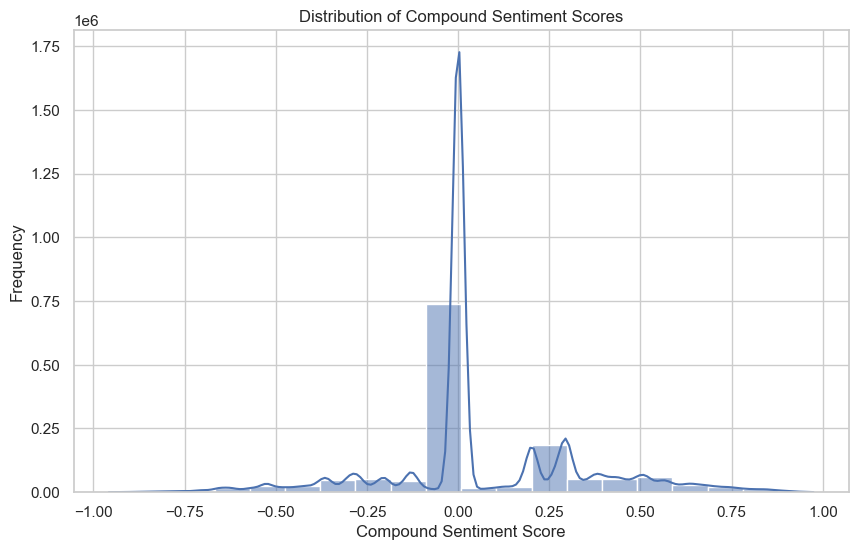

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['compound'], bins=20, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

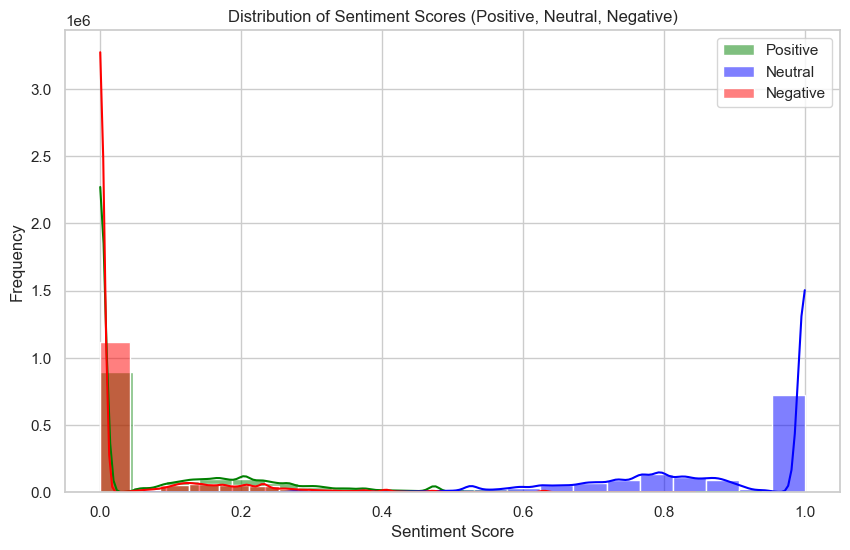

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['pos'], bins=20, kde=True, color='green', label='Positive')
sns.histplot(df['neu'], bins=20, kde=True, color='blue', label='Neutral')
sns.histplot(df['neg'], bins=20, kde=True, color='red', label='Negative')
plt.title('Distribution of Sentiment Scores (Positive, Neutral, Negative)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [9]:
df['sentiment_category'] = df['compound'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
sentiment_counts = df['sentiment_category'].value_counts()


C:\Users\USER\AppData\Local\Temp\ipykernel_13552\949553726.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


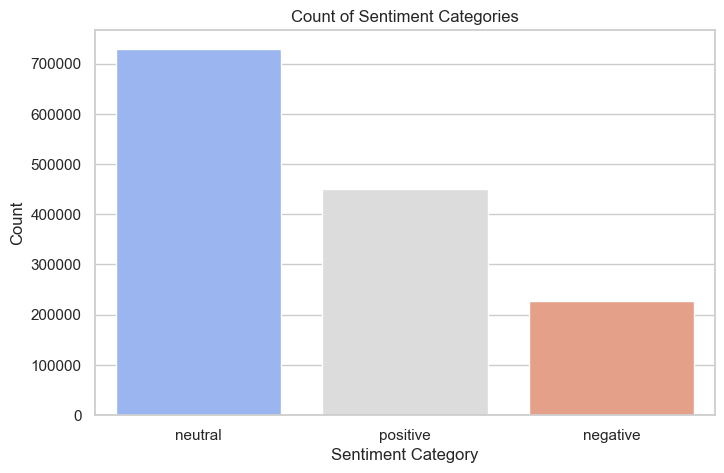

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Count of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:

stock_sentiment = df.groupby('stock')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()

print(stock_sentiment.head())


  stock       neg       neu       pos  compound
0     A  0.035067  0.889290  0.075646  0.071116
1    AA  0.048612  0.881911  0.069472  0.042593
2   AAC  0.034623  0.905611  0.059759  0.029539
3  AADR  0.000000  0.904000  0.096000  0.084750
4   AAL  0.054543  0.877557  0.067887  0.064993


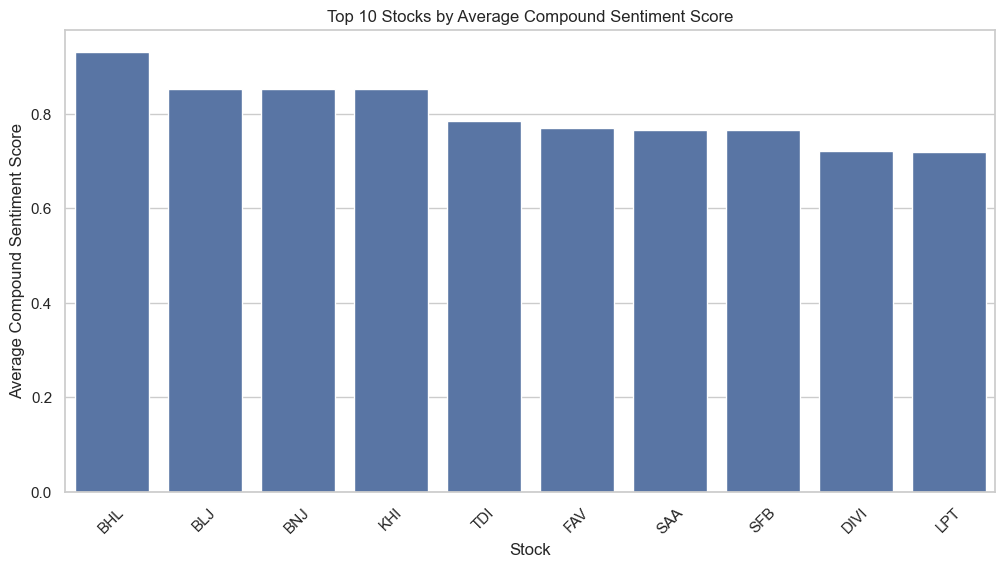

In [16]:
top_stocks = stock_sentiment.nlargest(10, 'compound')

plt.figure(figsize=(12, 6))
sns.barplot(x='stock', y='compound', data=top_stocks)
plt.title('Top 10 Stocks by Average Compound Sentiment Score')
plt.xlabel('Stock')
plt.ylabel('Average Compound Sentiment Score')
plt.xticks(rotation=45)
plt.show()

Topic Modeling

In [26]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sample_size = 2000 
df_sampled = df.sample(n=sample_size, random_state=42)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df_sampled['headline'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
pt buy earnings price target raises maintains downgrades upgrades morgan
Topic 1:
week stocks 52 new announces yesterday biggest hit lows movers
Topic 2:
benzinga stocks etfs industry says shares highest watch price bank
Topic 3:
vs est eps reports sales trading shares q3 q2 q4
Topic 4:
market stocks mid session moving update day pre shares tuesday
